# 1. Import Library

In [2]:
# Import Library
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier  

from sklearn.metrics import classification_report, confusion_matrix
import joblib

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [33]:
# === BASE PATH SETUP ===
BASE_DIR = r".."
DATASET_DIR = os.path.join(BASE_DIR, "Dataset")
OUTPUT_DIR  = os.path.join(BASE_DIR, "Output_Data")
FEATURE_DIR = os.path.join(BASE_DIR, "Features")
MODEL_DIR   = os.path.join(BASE_DIR, "Models")

# create dirs if not exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

ALL_DATA_CSV = os.path.join(BASE_DIR, "all_data.csv")
FEATURES_CSV = os.path.join(FEATURE_DIR, "features_df.csv")
MODEL_FILE   = os.path.join(MODEL_DIR, "xgboost_model.pkl")

ACTIVITIES = [
    "Rest", "Sprint", "Walking"
]

WINDOW_SIZE = 150      
STEP_SIZE   = 100      

print("📁 Ready — All paths set.")

📁 Ready — All paths set.


# 2. Load Data per Activity

In [36]:
print("📥 Loading dataset per activity...")
data_dict = {}
for act in ACTIVITIES:
    fp = os.path.join(OUTPUT_DIR, f"{act}.csv")
    if os.path.exists(fp):
        data_dict[act] = pd.read_csv(fp)
        print(f"  ✓ Loaded: {act} ({len(data_dict[act])} rows)")
    else:
        print(f"  ⚠️ Missing: {act}")

print("\n✅ Data loading complete.")

📥 Loading dataset per activity...
  ✓ Loaded: Rest (735406 rows)
  ✓ Loaded: Sprint (755067 rows)
  ✓ Loaded: Walking (744997 rows)

✅ Data loading complete.


# 3.Visualisasi Jumlah data per aktivitas

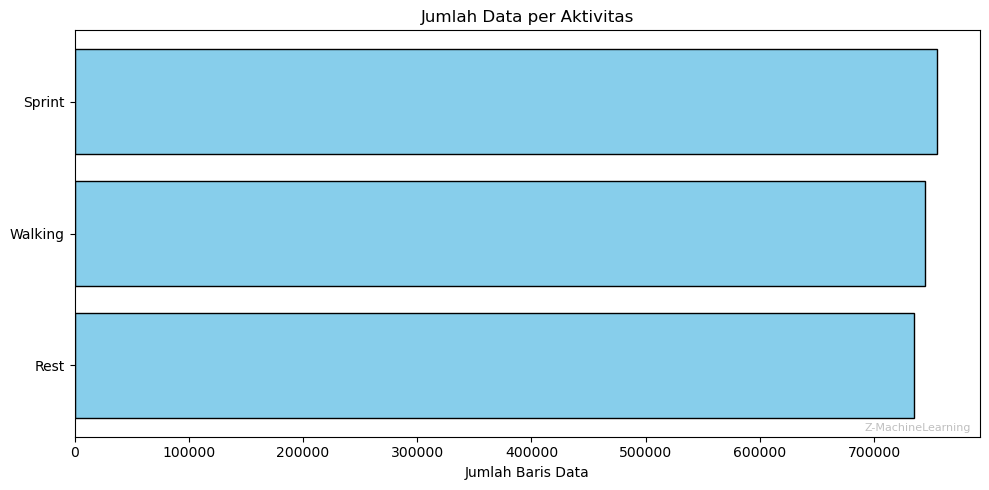

Rest       735406
Walking    744997
Sprint     755067
dtype: int64

In [70]:
counts = {act: len(data_dict[act]) for act in data_dict.keys()}
s = pd.Series(counts).sort_values(ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(s.index, s.values, color="skyblue", edgecolor="black")
plt.title("Jumlah Data per Aktivitas")
plt.xlabel("Jumlah Baris Data")
plt.tight_layout()
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()

s

# 4. Ekstraksi Features

In [42]:
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

if not os.path.exists(FEATURES_CSV):
    print("🚀 Ekstraksi fitur dimulai...")
    all_features = []
    for act, df in data_dict.items():
        for i in tqdm(range(0, len(df) - WINDOW_SIZE, STEP_SIZE), desc=f"{act}"):
            window = df.iloc[i:i+WINDOW_SIZE]
            f = extract_features_from_window(window)
            f["Activity"] = act
            all_features.append(f)
    features_df = pd.DataFrame(all_features)
    features_df.to_csv(FEATURES_CSV, index=False)
    print(f"✅ fitur disimpan ke: {FEATURES_CSV}  | Total rows: {len(features_df)}")

else:
    print("📂 fitur sudah ada — loading...")
    features_df = pd.read_csv(FEATURES_CSV)

features_df.head()

📂 fitur sudah ada — loading...


,Accel_X_mean,Accel_X_std,Accel_X_max,Accel_X_min,Accel_X_range,Accel_X_energy,Accel_Y_mean,Accel_Y_std,Accel_Y_max,Accel_Y_min,...,Mag_Y_min,Mag_Y_range,Mag_Y_energy,Mag_Z_mean,Mag_Z_std,Mag_Z_max,Mag_Z_min,Mag_Z_range,Mag_Z_energy,Activity
0,2.029066,0.322486,2.434697,1.323829,1.110868,4.221105,2.352424,0.551585,3.400799,1.537987,...,8.564400,1.4274,90.932489,30.791986,0.593347,31.976200,29.914400,2.061800,948.498477,Rest
1,2.365186,0.249460,3.047858,2.037488,1.010369,5.656333,2.766917,0.512215,3.415156,1.945365,...,8.356999,1.2200,83.467032,32.004503,0.690105,33.244999,30.817200,2.427799,1024.764465,Rest
2,2.499802,0.346212,3.119642,1.860420,1.259223,6.368872,2.246753,0.416222,2.912663,1.542772,...,7.222400,1.9764,67.361071,32.390186,0.394915,33.244999,31.951799,1.293200,1049.280132,Rest
3,3.084624,0.702618,4.029513,1.860420,2.169094,10.008574,1.769572,0.182078,2.218147,1.427917,...,7.222400,0.8662,59.790792,33.042398,0.809635,34.635799,31.951799,2.684000,1092.455570,Rest
4,3.707898,0.257984,4.029513,3.234498,0.795015,13.815063,1.717736,0.331774,2.045863,0.652642,...,7.234600,1.2932,62.941020,35.802851,1.887820,39.161999,32.952198,6.209801,1285.408007,Rest


# 5. Training Model XGBoost

In [45]:
# ========== Cell 5: Train XGBoost Classifier ==========

X = features_df.drop(columns=["Activity"])
y = features_df["Activity"]

# encode label
le = LabelEncoder()
y_enc = le.fit_transform(y)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 🔥 GANTI RANDOM FOREST → XGBOOST
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss"  
)

print("🚀 Training model (XGBoost)...")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save model
joblib.dump(model, MODEL_FILE)
print(f"\n✅ Model XGBoost disimpan ke: {MODEL_FILE}")


🚀 Training model (XGBoost)...

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

        Rest       1.00      0.99      1.00      1471
      Sprint       0.99      0.99      0.99      1510
     Walking       0.99      0.99      0.99      1490

    accuracy                           0.99      4471
   macro avg       0.99      0.99      0.99      4471
weighted avg       0.99      0.99      0.99      4471


✅ Model XGBoost disimpan ke: ..\Models\xgboost_model.pkl


# 6. Confusion Matrix

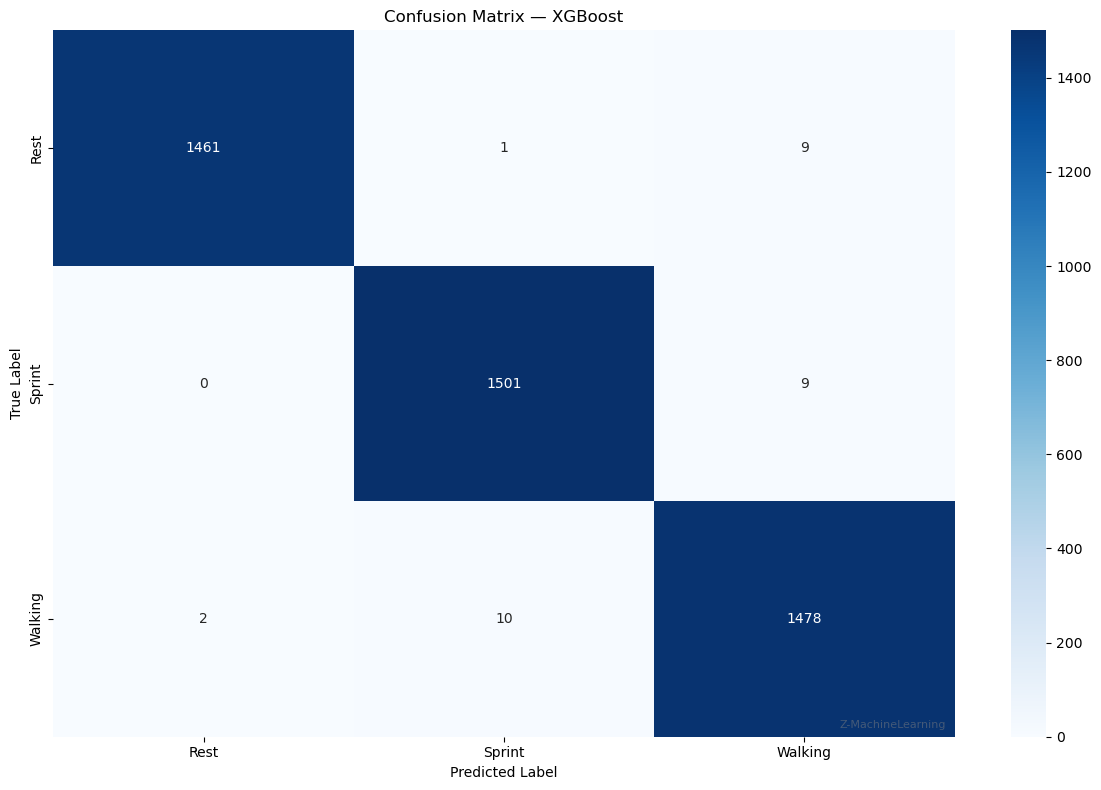

In [72]:
# ========== Cell 6: Confusion Matrix ==========

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — XGBoost")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()

# 7. Feature Importance

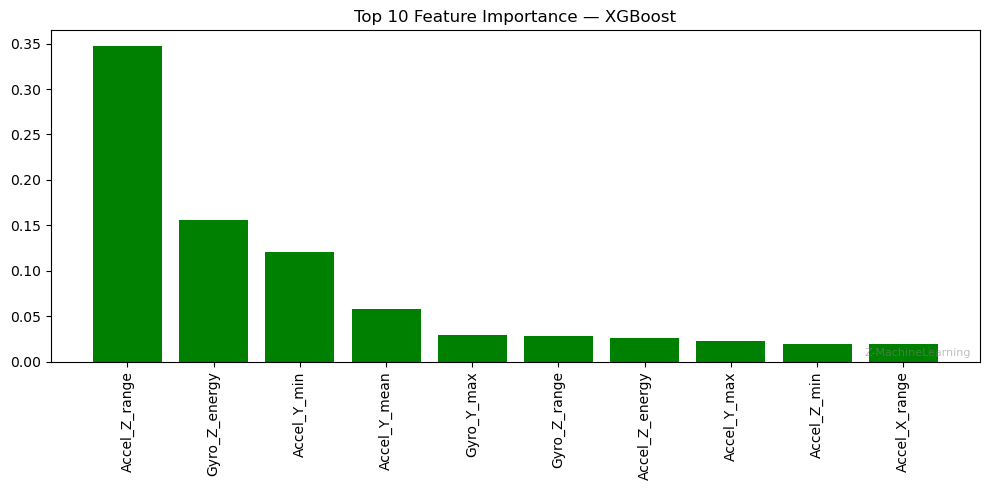

In [74]:
# ========== Cell 7: Feature Importance ==========

importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10,5))
plt.bar(range(len(idx)), importances[idx], color="green")
plt.xticks(range(len(idx)), X.columns[idx], rotation=90)
plt.title("Top 10 Feature Importance — XGBoost")
plt.tight_layout()
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()

# 8. Tes Model XGBoost


=== XGBOOST — HASIL UTAMA ===
Aktivitas: Walking

Penjelasan: Objek sedang berjalan


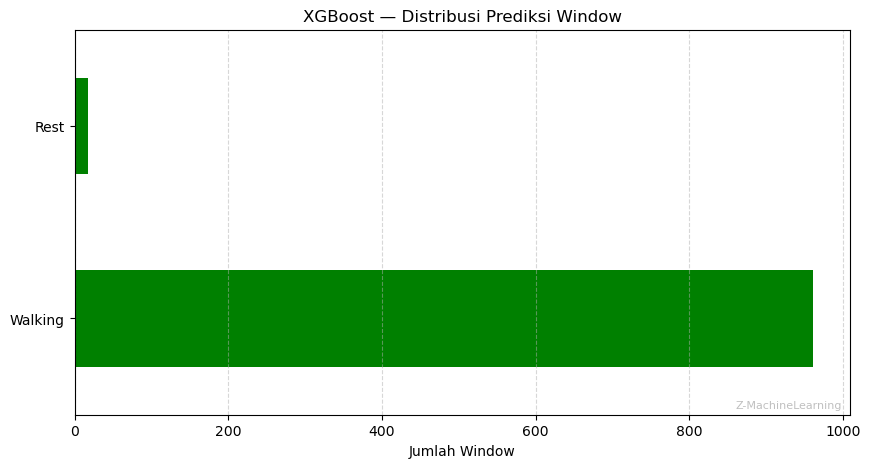

In [76]:
# path model
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\Models\xgboost_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\New_Data\New_Walking_1"

accel = pd.read_csv(os.path.join(NEW_FOLDER, "Accelerometer.csv"))
gyro  = pd.read_csv(os.path.join(NEW_FOLDER, "Gyroscope.csv"))
mag   = pd.read_csv(os.path.join(NEW_FOLDER, "Magnetometer.csv"))

for df in [accel, gyro, mag]:
    df["Time (s)"] = df["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns  = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns   = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

def extract_features(window):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        v = window[col].values
        feats[f"{col}_mean"] = v.mean()
        feats[f"{col}_std"] = v.std()
        feats[f"{col}_max"] = v.max()
        feats[f"{col}_min"] = v.min()
        feats[f"{col}_range"] = v.max() - v.min()
        feats[f"{col}_energy"] = np.sum(v**2) / len(v)
    return feats

WINDOW_SIZE = 150
STEP_SIZE = 100

windows = []
for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    windows.append(extract_features(window))

features_df = pd.DataFrame(windows)
model = joblib.load(MODEL_PATH)
preds = model.predict(features_df)

activity_labels = [
    "Rest", "Sprint", "Walking"
]

decoded = [activity_labels[i] for i in preds]
majority = pd.Series(decoded).value_counts().idxmax()

print("\n=== XGBOOST — HASIL UTAMA ===")
print("Aktivitas:", majority)

interpretasi = {
    "Rest": "Objek sedang istirahat",
    "Sprint": "Objek sedang berlari",
    "Walking": "Objek sedang berjalan",
}

print("\nPenjelasan:", interpretasi.get(majority))

plt.figure(figsize=(10,5))
pd.Series(decoded).value_counts().plot(kind="barh", color="green")
plt.title("XGBoost — Distribusi Prediksi Window")
plt.xlabel("Jumlah Window")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()


=== XGBOOST — HASIL UTAMA ===
Aktivitas: Walking

Penjelasan: Objek sedang berjalan


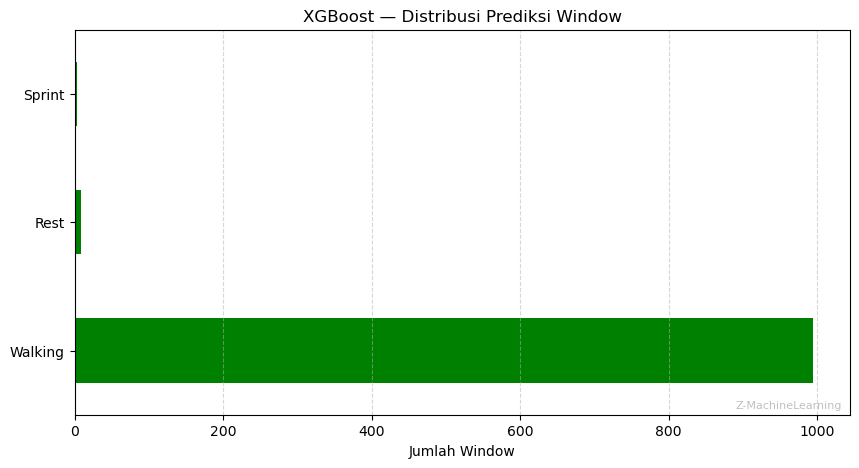

In [78]:
# path model
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\Models\xgboost_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\New_Data\New_Walking_2"

accel = pd.read_csv(os.path.join(NEW_FOLDER, "Accelerometer.csv"))
gyro  = pd.read_csv(os.path.join(NEW_FOLDER, "Gyroscope.csv"))
mag   = pd.read_csv(os.path.join(NEW_FOLDER, "Magnetometer.csv"))

for df in [accel, gyro, mag]:
    df["Time (s)"] = df["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns  = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns   = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

def extract_features(window):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        v = window[col].values
        feats[f"{col}_mean"] = v.mean()
        feats[f"{col}_std"] = v.std()
        feats[f"{col}_max"] = v.max()
        feats[f"{col}_min"] = v.min()
        feats[f"{col}_range"] = v.max() - v.min()
        feats[f"{col}_energy"] = np.sum(v**2) / len(v)
    return feats

WINDOW_SIZE = 150
STEP_SIZE = 100

windows = []
for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    windows.append(extract_features(window))

features_df = pd.DataFrame(windows)
model = joblib.load(MODEL_PATH)
preds = model.predict(features_df)

activity_labels = [
    "Rest", "Sprint", "Walking"
]

decoded = [activity_labels[i] for i in preds]
majority = pd.Series(decoded).value_counts().idxmax()

print("\n=== XGBOOST — HASIL UTAMA ===")
print("Aktivitas:", majority)

interpretasi = {
    "Rest": "Objek sedang istirahat",
    "Sprint": "Objek sedang berlari",
    "Walking": "Objek sedang berjalan",
}

print("\nPenjelasan:", interpretasi.get(majority))

plt.figure(figsize=(10,5))
pd.Series(decoded).value_counts().plot(kind="barh", color="green")
plt.title("XGBoost — Distribusi Prediksi Window")
plt.xlabel("Jumlah Window")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()


=== XGBOOST — HASIL UTAMA ===
Aktivitas: Sprint

Penjelasan: Objek sedang berlari


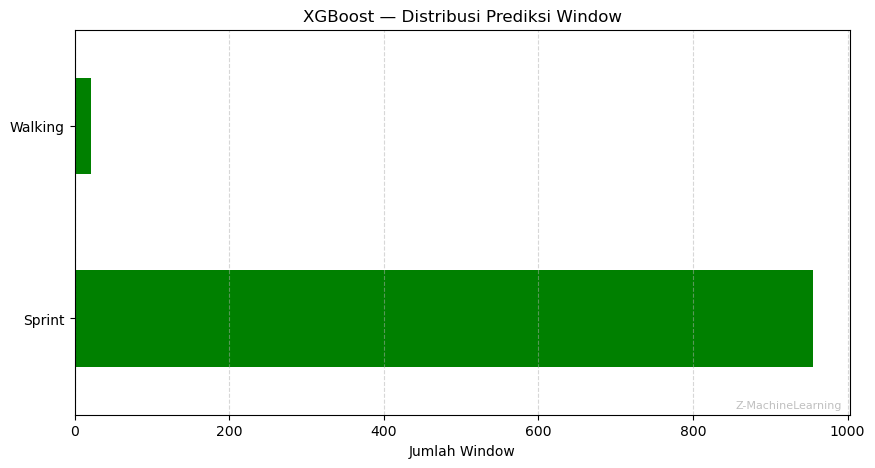

In [80]:
# path model
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\Models\xgboost_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\New_Data\New_Sprint_1"

accel = pd.read_csv(os.path.join(NEW_FOLDER, "Accelerometer.csv"))
gyro  = pd.read_csv(os.path.join(NEW_FOLDER, "Gyroscope.csv"))
mag   = pd.read_csv(os.path.join(NEW_FOLDER, "Magnetometer.csv"))

for df in [accel, gyro, mag]:
    df["Time (s)"] = df["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns  = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns   = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

def extract_features(window):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        v = window[col].values
        feats[f"{col}_mean"] = v.mean()
        feats[f"{col}_std"] = v.std()
        feats[f"{col}_max"] = v.max()
        feats[f"{col}_min"] = v.min()
        feats[f"{col}_range"] = v.max() - v.min()
        feats[f"{col}_energy"] = np.sum(v**2) / len(v)
    return feats

WINDOW_SIZE = 150
STEP_SIZE = 100

windows = []
for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    windows.append(extract_features(window))

features_df = pd.DataFrame(windows)
model = joblib.load(MODEL_PATH)
preds = model.predict(features_df)

activity_labels = [
    "Rest", "Sprint", "Walking"
]

decoded = [activity_labels[i] for i in preds]
majority = pd.Series(decoded).value_counts().idxmax()

print("\n=== XGBOOST — HASIL UTAMA ===")
print("Aktivitas:", majority)

interpretasi = {
    "Rest": "Objek sedang istirahat",
    "Sprint": "Objek sedang berlari",
    "Walking": "Objek sedang berjalan",
}

print("\nPenjelasan:", interpretasi.get(majority))

plt.figure(figsize=(10,5))
pd.Series(decoded).value_counts().plot(kind="barh", color="green")
plt.title("XGBoost — Distribusi Prediksi Window")
plt.xlabel("Jumlah Window")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()


=== XGBOOST — HASIL UTAMA ===
Aktivitas: Sprint

Penjelasan: Objek sedang berlari


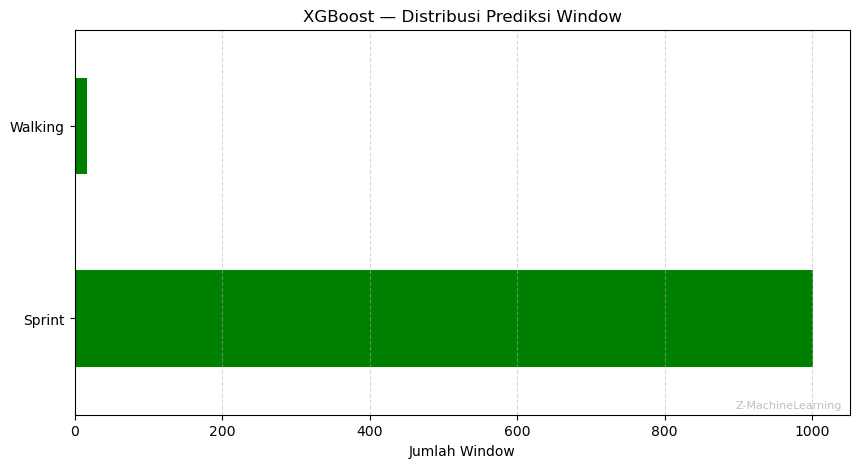

In [82]:
# path model
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\Models\xgboost_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\New_Data\New_Sprint_2"

accel = pd.read_csv(os.path.join(NEW_FOLDER, "Accelerometer.csv"))
gyro  = pd.read_csv(os.path.join(NEW_FOLDER, "Gyroscope.csv"))
mag   = pd.read_csv(os.path.join(NEW_FOLDER, "Magnetometer.csv"))

for df in [accel, gyro, mag]:
    df["Time (s)"] = df["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns  = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns   = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

def extract_features(window):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        v = window[col].values
        feats[f"{col}_mean"] = v.mean()
        feats[f"{col}_std"] = v.std()
        feats[f"{col}_max"] = v.max()
        feats[f"{col}_min"] = v.min()
        feats[f"{col}_range"] = v.max() - v.min()
        feats[f"{col}_energy"] = np.sum(v**2) / len(v)
    return feats

WINDOW_SIZE = 150
STEP_SIZE = 100

windows = []
for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    windows.append(extract_features(window))

features_df = pd.DataFrame(windows)
model = joblib.load(MODEL_PATH)
preds = model.predict(features_df)

activity_labels = [
    "Rest", "Sprint", "Walking"
]

decoded = [activity_labels[i] for i in preds]
majority = pd.Series(decoded).value_counts().idxmax()

print("\n=== XGBOOST — HASIL UTAMA ===")
print("Aktivitas:", majority)

interpretasi = {
    "Rest": "Objek sedang istirahat",
    "Sprint": "Objek sedang berlari",
    "Walking": "Objek sedang berjalan",
}

print("\nPenjelasan:", interpretasi.get(majority))

plt.figure(figsize=(10,5))
pd.Series(decoded).value_counts().plot(kind="barh", color="green")
plt.title("XGBoost — Distribusi Prediksi Window")
plt.xlabel("Jumlah Window")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()


=== XGBOOST — HASIL UTAMA ===
Aktivitas: Rest

Penjelasan: Objek sedang istirahat


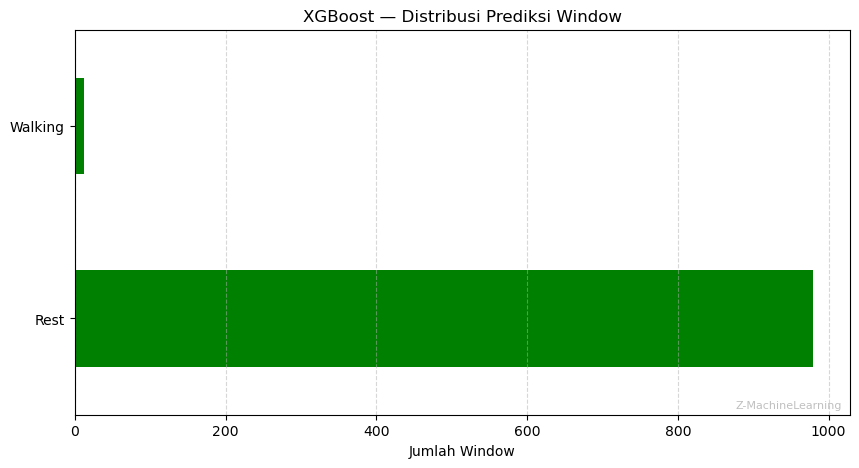

In [84]:
# path model
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\Models\xgboost_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\New_Data\New_Rest_1"

accel = pd.read_csv(os.path.join(NEW_FOLDER, "Accelerometer.csv"))
gyro  = pd.read_csv(os.path.join(NEW_FOLDER, "Gyroscope.csv"))
mag   = pd.read_csv(os.path.join(NEW_FOLDER, "Magnetometer.csv"))

for df in [accel, gyro, mag]:
    df["Time (s)"] = df["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns  = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns   = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

def extract_features(window):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        v = window[col].values
        feats[f"{col}_mean"] = v.mean()
        feats[f"{col}_std"] = v.std()
        feats[f"{col}_max"] = v.max()
        feats[f"{col}_min"] = v.min()
        feats[f"{col}_range"] = v.max() - v.min()
        feats[f"{col}_energy"] = np.sum(v**2) / len(v)
    return feats

WINDOW_SIZE = 150
STEP_SIZE = 100

windows = []
for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    windows.append(extract_features(window))

features_df = pd.DataFrame(windows)
model = joblib.load(MODEL_PATH)
preds = model.predict(features_df)

activity_labels = [
    "Rest", "Sprint", "Walking"
]

decoded = [activity_labels[i] for i in preds]
majority = pd.Series(decoded).value_counts().idxmax()

print("\n=== XGBOOST — HASIL UTAMA ===")
print("Aktivitas:", majority)

interpretasi = {
    "Rest": "Objek sedang istirahat",
    "Sprint": "Objek sedang berlari",
    "Walking": "Objek sedang berjalan",
}

print("\nPenjelasan:", interpretasi.get(majority))

plt.figure(figsize=(10,5))
pd.Series(decoded).value_counts().plot(kind="barh", color="green")
plt.title("XGBoost — Distribusi Prediksi Window")
plt.xlabel("Jumlah Window")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()


=== XGBOOST — HASIL UTAMA ===
Aktivitas: Rest

Penjelasan: Objek sedang istirahat


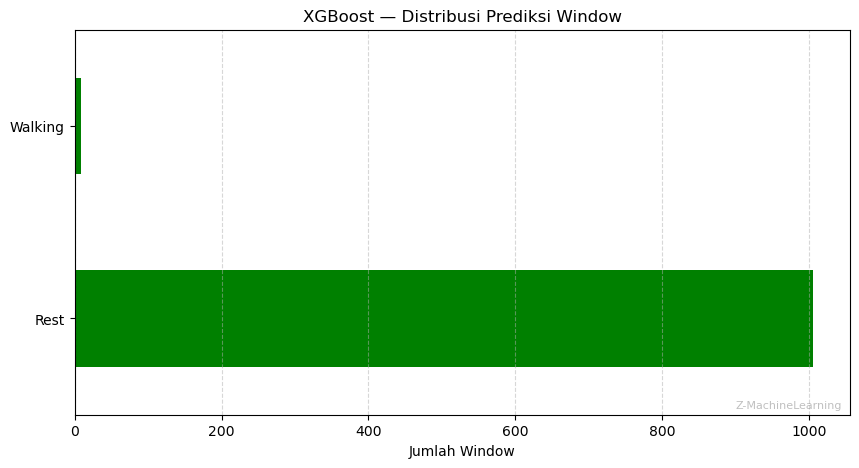

In [68]:
# path model
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\Models\xgboost_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Model XGBoost\New_Data\New_Rest_2"

accel = pd.read_csv(os.path.join(NEW_FOLDER, "Accelerometer.csv"))
gyro  = pd.read_csv(os.path.join(NEW_FOLDER, "Gyroscope.csv"))
mag   = pd.read_csv(os.path.join(NEW_FOLDER, "Magnetometer.csv"))

for df in [accel, gyro, mag]:
    df["Time (s)"] = df["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns  = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns   = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

def extract_features(window):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        v = window[col].values
        feats[f"{col}_mean"] = v.mean()
        feats[f"{col}_std"] = v.std()
        feats[f"{col}_max"] = v.max()
        feats[f"{col}_min"] = v.min()
        feats[f"{col}_range"] = v.max() - v.min()
        feats[f"{col}_energy"] = np.sum(v**2) / len(v)
    return feats

WINDOW_SIZE = 150
STEP_SIZE = 100

windows = []
for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    windows.append(extract_features(window))

features_df = pd.DataFrame(windows)
model = joblib.load(MODEL_PATH)
preds = model.predict(features_df)

activity_labels = [
    "Rest", "Sprint", "Walking"
]

decoded = [activity_labels[i] for i in preds]
majority = pd.Series(decoded).value_counts().idxmax()

print("\n=== XGBOOST — HASIL UTAMA ===")
print("Aktivitas:", majority)

interpretasi = {
    "Rest": "Objek sedang istirahat",
    "Sprint": "Objek sedang berlari",
    "Walking": "Objek sedang berjalan",
}

print("\nPenjelasan:", interpretasi.get(majority))

plt.figure(figsize=(10,5))
pd.Series(decoded).value_counts().plot(kind="barh", color="green")
plt.title("XGBoost — Distribusi Prediksi Window")
plt.xlabel("Jumlah Window")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.text(
    0.99, 0.01, "Z-MachineLearning",
    transform=plt.gca().transAxes,
    fontsize=8,
    color='gray',
    ha='right',
    va='bottom',
    alpha=0.5
)
plt.show()